In [1]:
from math import ceil
from random import choices

from dtw import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [31]:
df = pd.read_csv("../data/df_approx_windows.csv")

In [4]:
df.head()

,ts_name,type,fhat,PSD,freq,freq_apx_idx,freq_apx
0,H101,fft,1.669116e+06,3.979926e+09,0.000000,0,0.000000
1,H101,fft,6.368073e+03,5.793194e+04,1.428571,119,1.458190
2,H101,fft,2.309107e+04,7.617110e+05,2.857143,149,2.865581
3,H101,fft,2.112334e+04,6.374224e+05,4.285714,167,4.297856
4,H101,fft,9.239087e+03,1.219439e+05,5.714286,180,5.759585


In [32]:
names = []
types = []
freqs = []


for elm in tqdm(df.groupby(['ts_name', 'type'])):
    names.append(elm[0][0])
    types.append(elm[0][1])
    
    df_sub = elm[1]
    df_sub.sort_values("PSD", ascending=False, inplace=True)
    freqs.append(df_sub[:5]['freq_apx_idx'].to_list())

df_reduced = pd.DataFrame({
    'ts_name': names,
    'type': types,
    'freqs': freqs
})

  0%|          | 0/300000 [00:00<?, ?it/s]

In [33]:
df_reduced.to_csv("../df_top_5_freq_windows.csv", index=False)

In [34]:
df_reduced[df_reduced['type']=='Welch'][:150]

,ts_name,type,freqs
1,D1,Welch,"[0, 0, 0, 0, 0]"
4,D10,Welch,"[0, 0, 0, 0, 9]"
7,D100,Welch,"[0, 0, 0, 0, 0]"
10,D1000,Welch,"[0, 0, 0, 0, 0]"
13,D1001,Welch,"[0, 0, 0, 0, 0]"
...,...,...,...
436,D1129,Welch,"[0, 0, 0, 0, 0]"
439,D113,Welch,"[0, 0, 0, 0, 0]"
442,D1130,Welch,"[0, 0, 0, 0, 0]"
445,D1131,Welch,"[0, 0, 0, 0, 0]"


### Compute frequency matches b/w methods

In [35]:
names = []
types = []
match_ratios = []

for elm in tqdm(df_reduced.groupby("ts_name")):
    name=elm[0]
    df_sub = elm[1]
    # generate arrays for matching freqs
    freqs_fft = np.array(df_sub.loc[df_sub['type']=='fft', 'freqs'].reset_index(drop=True)[0])
    freqs_hamming = np.array(df_sub.loc[df_sub['type']=='Hamming', 'freqs'].reset_index(drop=True)[0])
    freqs_welch = np.array(df_sub.loc[df_sub['type']=='Welch', 'freqs'].reset_index(drop=True)[0])  
    
    # create matching frequ
    match_fft_hamming = np.sum((freqs_fft == freqs_hamming))/len(freqs_fft)
    match_fft_welch = np.sum((freqs_fft == freqs_welch))/len(freqs_fft)
    match_hamming_welch = np.sum((freqs_hamming == freqs_welch))/len(freqs_hamming)
    
    # generate data
    names.extend([name]*3)
    types.extend(['fft_hamming', 'fft_welch', 'hamming_welch'])
    match_ratios.extend([match_fft_hamming, match_fft_welch, match_hamming_welch])

df_match = pd.DataFrame({
    'ts_name': names,
    'type': types,
    'match_ratio': match_ratios
})
df_match.head()

  0%|          | 0/100000 [00:00<?, ?it/s]

<ipython-input-35-274b01a6613f>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  match_fft_welch = np.sum((freqs_fft == freqs_welch))/len(freqs_fft)
<ipython-input-35-274b01a6613f>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  match_hamming_welch = np.sum((freqs_hamming == freqs_welch))/len(freqs_hamming)


,ts_name,type,match_ratio
0,D1,fft_hamming,0.6
1,D1,fft_welch,0.2
2,D1,hamming_welch,0.2
3,D10,fft_hamming,0.4
4,D10,fft_welch,0.2


In [36]:
df_match.shape

(300000, 3)

In [37]:
df_match.head()

,ts_name,type,match_ratio
0,D1,fft_hamming,0.6
1,D1,fft_welch,0.2
2,D1,hamming_welch,0.2
3,D10,fft_hamming,0.4
4,D10,fft_welch,0.2


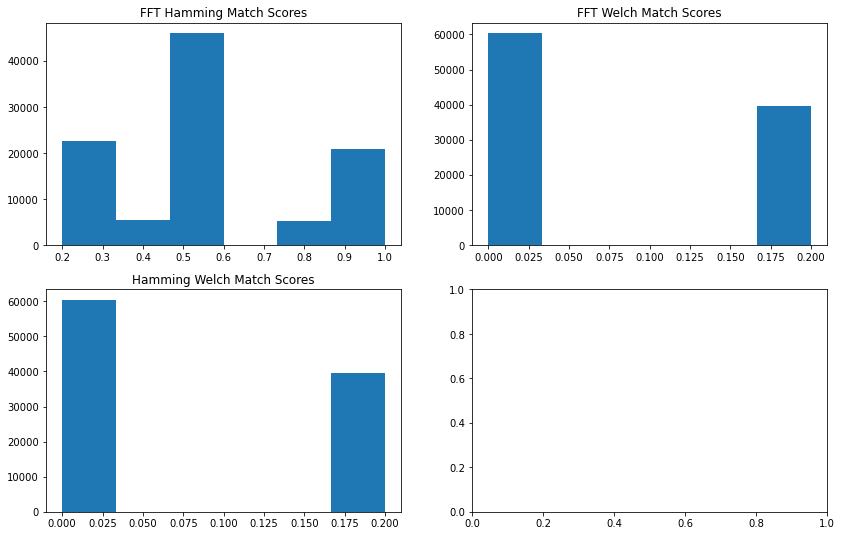

In [86]:
fig, axs = plt.subplots(2, 2, figsize=(14,9))

axs.flatten()[0].hist(df_match[df_match['type']=='fft_hamming']['match_ratio'], bins=6)
axs.flatten()[0].title.set_text("FFT Hamming Match Scores")
axs.flatten()[1].hist(df_match[df_match['type']=='fft_welch']['match_ratio'], bins=6)
axs.flatten()[1].title.set_text("FFT Welch Match Scores")

axs.flatten()[2].hist(df_match[df_match['type']=='hamming_welch']['match_ratio'], bins=6)
axs.flatten()[2].title.set_text("Hamming Welch Match Scores")


results show that the frequencies are not matching between Hamming, Welch and regular FFT method
next step to verify which leads to better results

## Compute Match for different methods

In [205]:
df_reduced[df]

,ts_name,type,freqs
0,D1,Hamming,"[0, 102, 409, 409, 133]"
1,D1,Welch,"[0, 0, 0, 0, 0]"
2,D1,fft,"[0, 102, 409, 133, 409]"
3,D10,Hamming,"[0, 120, 409, 151, 409]"
4,D10,Welch,"[0, 0, 0, 0, 9]"


Generate Sample for which the matching is going to be computed

In [51]:
sample_ts = choices(df_reduced['ts_name'].unique(), k=1000)

In [52]:
len(sample_ts)

1000

In [40]:
def compare_freqs(tgt_fs: np.ndarray, **kwargs) -> int:
    if "src_fs" in kwargs:
        src_fs = kwargs['src_fs']
    else:
        raise Exception("source frequencies missing")
        
    
    # convert list to vector
    
    ## continue here - tgt_fs is all frequencies for each ts in a an array (99999, 5)
    tgt_fs = np.array(tgt_fs)
    src_fs = np.array(src_fs)
    
    # ensure length 5 for both vectors
    src_fs = np.pad(src_fs, (0, 5-src_fs.shape[0]),
                   constant_values=(-9999999,)) # use obscure value to avoid undesired match
    tgt_fs = np.pad(tgt_fs, (0, 5-src_fs.shape[0]),
                   constant_values=(-9999999,))
    
    match = (src_fs - tgt_fs)==0
    
    # flip vector to have least significant match first
    match = match[::-1]
    
    # multiply matches of freqs with increasing exponent
    # and sum results to allow for ranking
    return np.sum(match*(10**np.array(range(1,6))))
    
    
    
    

### ensure length of 5 for each freq list

In [41]:
def convert_to_ar(s: pd.Series) -> pd.Series:
    ar = np.array(s['freqs'])
    ar = np.pad(ar, (0, 5-ar.shape[0]),
                   constant_values=(-9999999,)) # use obscure value to avoid undesired match
    return ar

In [42]:
df_reduced['freqs'] = df_reduced.apply(convert_to_ar, axis=1)

### loop through reduced ts to find relevant matches

In [53]:
ts_names = []
types = []
candidates = []

for ts_src_name in tqdm(sample_ts):
    # find frequencies for each window type
    freqs_fft = df_reduced[(df_reduced['ts_name']==ts_src_name) &
                              (df_reduced['type']=="fft")]['freqs'].reset_index(drop=True)[0]
    freqs_hamming = df_reduced[(df_reduced['ts_name']==ts_src_name) &
                              (df_reduced['type']=="Hamming")]['freqs'].reset_index(drop=True)[0]
    freqs_welch = df_reduced[(df_reduced['ts_name']==ts_src_name) &
                              (df_reduced['type']=="Welch")]['freqs'].reset_index(drop=True)[0]
    
    map_window_d = {'fft': freqs_fft,
            'Hamming': freqs_hamming,
            'Welch': freqs_welch}
    # search most matching ts in each subset
    
    for elm in df_reduced.groupby('type'):
        window_type = elm[0]
        df_sub = elm[1]
        # match correct frequency for group
        ts_src_fs = map_window_d[window_type]
        # removing the time series under investigation
        df_sub = df_sub[df_sub['ts_name']!=ts_src_name]
        
        # convert freqs column to array
        ar = np.array(df_sub['freqs'].to_list())
        
        # apply along axis
        res = np.apply_along_axis(compare_freqs,1, ar, src_fs=ts_src_fs)
        
        # get largest n (15) indexes
        ind = np.argsort(res)[::-1][:15]
        
        # retrieve names for largest n indexes
        ts_candidates = df_reduced.loc[ind,'ts_name'].to_list()
        
        # extend lists with candidates
        ts_names.extend([ts_src_name]*len(ts_candidates))
        types.extend([window_type]*len(ts_candidates))
        candidates.extend(ts_candidates)
    
df_candidates = pd.DataFrame({
    'ts_name': ts_names,
    'type': types,
    'candidate': candidates
})
        

  0%|          | 0/1000 [00:00<?, ?it/s]

In [50]:
df_candidates.to_csv('../data/df_candidates_1000.csv', index=False)

### Compute distances for all identified series and choose smallest distances as winner

In [54]:
def compute_distance(s: pd.Series) -> pd.Series:
    ar_src = np.array(df_all[df_all['V1']==s['ts_name']].iloc[:,1:].dropna(axis=1))[0]
    ar_tgt = np.array(df_all[df_all['V1']==s['candidate']].iloc[:,1:].dropna(axis=1))[0]
    
    aln = dtw(ar_src, ar_tgt, keep_internals=True, distance_only=True)
    
    return aln.distance
        

In [55]:
df_candidates['dtw_dist'] = df_candidates.apply(compute_distance, axis=1)

In [56]:
df_candidates['type'].unique()

array(['Hamming', 'Welch', 'fft'], dtype=object)

### keep for each type the series with the lowest distance

In [57]:
df_winners = df_candidates.loc[df_candidates.groupby(['ts_name','type'], sort=False)['dtw_dist'].idxmin(axis=0)]

In [58]:
df_winners.to_csv("../data/df_winners_1000.csv")

### Plot the winners

In [5]:
df_winners = pd.read_csv("../data/df_winners.csv")

In [6]:
df_all.reset_index(drop=True, inplace=True)

In [7]:
df_winners = df_winners[:9]

In [11]:
df_winners.head()

,Unnamed: 0,ts_name,type,candidate,dtw_dist
0,14,M31076,Hamming,M15637,182891.500
1,16,M31076,Welch,M14234,91859.800
2,40,M31076,fft,M15628,194149.800
3,59,Q20663,Hamming,M26835,32803.424
4,65,Q20663,Welch,M22536,943546.000


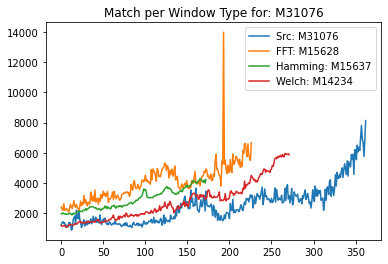

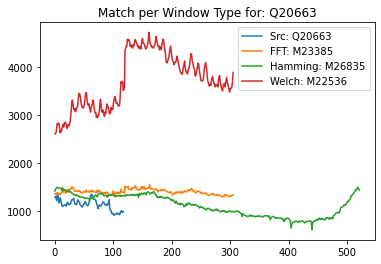

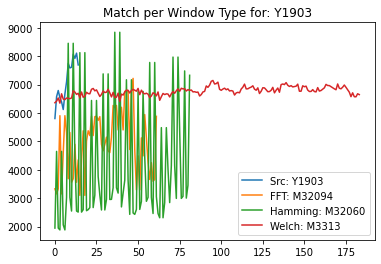

In [29]:
for elm in df_winners.groupby("ts_name"):
    src_name = elm[0]
    df_sub = elm[1]
    
    fft_name = df_sub[df_sub['type']=='fft']['candidate'].values[0]
    ham_name = df_sub[df_sub['type']=='Hamming']['candidate'].values[0]
    wel_name = df_sub[df_sub['type']=='Welch']['candidate'].values[0]

    
    ar_src = np.array(df_all[df_all['V1']==src_name].iloc[:,1:].dropna(axis=1))[0]
    ar_fft = np.array(df_all[df_all['V1']==fft_name].iloc[:,1:].dropna(axis=1))[0]
    ar_ham = np.array(df_all[df_all['V1']==ham_name].iloc[:,1:].dropna(axis=1))[0]
    ar_wel = np.array(df_all[df_all['V1']==wel_name].iloc[:,1:].dropna(axis=1))[0]

    
    plt.plot(ar_src, '-', label="Src: " + src_name)
    plt.plot(ar_fft, label="FFT: " + fft_name)
    plt.plot(ar_ham, label="Hamming: "+ ham_name)
    label_wel = "Welch: " + wel_name
    plt.plot(ar_wel, label=label_wel)
    plt.legend()
    plt.title("Match per Window Type for: " + src_name)
    #plt.savefig("../img/src_name+".png")
    plt.show()
    plt.close()

In [1]:
for idx,row in df_winners.iterrows():
    ar_src = np.array(df_all[df_all['V1']==row['ts_name']].iloc[:,1:].dropna(axis=1))[0]
    ar_tgt = np.array(df_all[df_all['V1']==row['candidate']].iloc[:,1:].dropna(axis=1))[0]
    
    plt.plot(ar_src, "-", label=row['ts_name'])
    plt.plot(ar_tgt, "--", label=row['candidate'])
    plt.legend()
    plt.title(row['type'])
    plt.show()
    plt.close()

NameError: name 'df_winners' is not defined

In [ ]:
src_ts = 'H1'
tgt_ts = ['H161', 'H115', 'H59', 'H13', 'H21',
         'H70', 'H142', 'H72', 'H53', 'H75',
         'H77', 'H79', 'H23', 'H168', 'H42']



fig, axes = plt.subplots(3, 5, figsize=(13,9))
ar_src = np.array(df_hourly[df_hourly['V1']==src_ts].iloc[:,1:].dropna(axis=1))[0]
error = []
for i in tqdm(range(len(tgt_ts))):
    ts_name = tgt_ts[i]
    ar_tgt = np.array(df_hourly[df_hourly['V1']==ts_name].iloc[:,1:].dropna(axis=1))[0]
    
    # compute distance b/w src and target
    error.append(np.square(np.abs(ar_src) - np.abs(ar_tgt)).sum())
    
    # create plots
    axes.flatten()[i].plot(ar_src, "-", linewidth=2, label=src_ts)
    axes.flatten()[i].plot(ar_tgt, "--", linewidth=2, label=ts_name)
    title = src_ts + " and " + ts_name
    axes.flatten()[i].title.set_text(title)
    fig.suptitle("Matching of Hourly time series")
plt.show()

### loading the time series data

In [2]:
df_hourly = pd.read_csv("../m4_data/Hourly-train.csv")
print("hourly: {}".format(df_hourly.shape))
df_daily = pd.read_csv("../m4_data/Daily-train.csv")
print("daily: {}".format(df_daily.shape))
df_weekly = pd.read_csv("../m4_data/Weekly-train.csv")
print("weekly: {}".format(df_weekly.shape))
df_monthly = pd.read_csv("../m4_data/Monthly-train.csv")
print("monthly: {}".format(df_monthly.shape))
df_quarterly = pd.read_csv("../m4_data/Quarterly-train.csv")
print("quarterly: {}".format(df_quarterly.shape))
df_yearly = pd.read_csv("../m4_data/Yearly-train.csv")
print("yearly: {}".format(df_yearly.shape))

hourly: (414, 961)
daily: (4227, 9920)
weekly: (359, 2598)
monthly: (48000, 2795)
quarterly: (24000, 867)
yearly: (23000, 836)


In [3]:
df_all = pd.concat([df_hourly,
                   df_daily,
                   df_weekly,
                    df_monthly,
                   df_quarterly,
                   df_yearly])

In [4]:
df_hourly = None
df_daily = None
df_weekly = None
df_monthly = None
df_quarterly = None
df_yearly = None